# Rethink Priorities Skills Assessment


I want to consider some questions and log some hypotheses before I look at the data. Actually, though, I already clicked on the link and looked at the sheet so I'm not properly blink. Anyway, here are some questions and hypotheses:

 - What's the distribution of "when did you join EA?" I'm highly confident there will be fewer from 2015 than from 2016 etc. People who join will dropout over time. I also expect that the movement is growing, for example the [2019](https://files.givewell.org/files/metrics/GiveWell_Metrics_Report_2019.pdf) and [2018](https://files.givewell.org/files/metrics/GiveWell_Metrics_Report_2019.pdf) givewell reports indicate a growing number of donors from 2016 through 2019. I lean towards expecting that people who have been involved for more than 1 year are more likely to stay for additional years than people who have not yet been involved for 1 year, so the drop from the most recent to the second most recent year may be larger in percentage terms than between other years.
 - Are most non-student participants student recruits who have persisted or non-student recruits? This isn't totally resolvable with the given data, but we can get some evidence if we make assumptions about stability of new recruit demographics. My guess is 55% yes.
 - Does self-rated level of involvement correlate with time involved? I 75% expect it does. People who are highly involved should be more likely to stay involved. Furthermore, people who have been involved longer have probably found more ways to be involved. I expect the correlation to be weaker if most people who answer the survey remain involved for many years. If these are not strongly correlated, my best guess is that individual people's "self-rated level of involvement" may vary a lot over time.
 - How much diversity is there in cause prioritisation? I lean towards (60%) expecting that 1-2 causes capture the majority of top priorities because I expect that most people become engaged with Effective Altruism are already interested in a particular cause, and I expect some causes to be much more popular in the communities EA recruits from.
     - Are there "cause clusters"? There might be because e.g. people who have joined EA because of shared interest in a particular cause might have a different pattern of cause priority to people who have been in EA a long time and have thought about cause prioritisation informed by other EA work. OTOH there could easily be about as many different ways to prioritise causes as there are causes surveyed, so I'm about 51% on this.
 - Are there differences in cause priortisation between people who have just joined and people who have been involved for a long time? I have some expectation (60%) that people who have been engaged longer will be more likely to prioritise "longtermist"  causes over "helping people here and now" causes because longtermism is something many people are introduced to after meeting EA. I think longtermist causes here would be asteroid collisions, nuclear war and pandemic preparedness. I also think mental health might fall into the category of "causes people drift towards over time", as understanding how best to help people flourish seems like an important long-term question, even if advances can also help people here and now.
     - Similarly for high vs low engagement

## Let's have a look at the data

You have to run the cells in order

In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import pingouin

import jax.numpy as jnp
from jax import random, vmap

import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS

In [3]:
sheet_url = "https://docs.google.com/spreadsheets/d/1pdWo_Q4FyHkL_E12zrp63HQA3txPs4TNGP2MgvO3Kfk/export?format=csv&id=1pdWo_Q4FyHkL_E12zrp63HQA3txPs4TNGP2MgvO3Kfk&gid=0"
    
data = pd.read_csv(sheet_url,index_col=0)
data.columns = data.columns.str.strip(' ')
data.head()

,student,Global Poverty,Homelessness,Mental health,Asteroid collisions,Nuclear warfare,Pandemic preparedness,Engagement,Region,When joined EA
subject,,,,,,,,,,
1,0,4,5,4,5,5,5,(3) Moderate engagement,USA/Canada,2019 or later
2,1,5,5,5,4,4,3,(2) Mild engagement,USA/Canada,2018
3,1,5,6,4,3,4,5,(3) Moderate engagement,Rest of world,2019 or later
4,0,6,6,4,2,3,4,(2) Mild engagement,USA/Canada,2017
5,1,5,4,2,4,4,4,(4) Considerable engagement,USA/Canada,2019 or later


In [4]:
# Not sure if it's been edited by hand, let's check if labels are consistent

for col in data.columns:
    print(data[col].unique())

[0 1]
['4' '5' '6' '2' '3' '(7) Highly important' '(1) Not at all important']
['5' '6' '4' '2' '3' '(7) Highly important' '(1) Not at all important']
['4' '5' '2' '6' '3' '(7) Highly important' '(1) Not at all important']
['5' '4' '3' '2' '6' '(7) Highly important' '(1) Not at all important']
['5' '4' '3' '6' '2' '(7) Highly important' '(1) Not at all important']
['5' '3' '4' '6' '(7) Highly important' '2' '(1) Not at all important']
['(3) Moderate engagement' '(2) Mild engagement'
 '(4) Considerable engagement' '(1) No engagement' '(5) High engagement']
['USA/Canada' 'Rest of world' 'UK' 'Europe']
['2019 or later' '2018' '2017' '2015 or before' '2016']


In [5]:
# Looks good. Let's take a simple approach to making the data numeric
# may wish to revisit the "year joined" method later, as "2015 or before" != 2015

repl = lambda m: m.group(0)

for col in data.columns:
    if data[col].dtype == object:
        if data[col].str.contains('[0-9]').any():
            data[col] = data[col].str.replace('[^0-9]',"").astype(int)
            print(data[col].unique())

[4 5 6 2 3 7 1]
[5 6 4 2 3 7 1]
[4 5 2 6 3 7 1]
[5 4 3 2 6 7 1]
[5 4 3 6 2 7 1]
[5 3 4 6 7 2 1]
[3 2 4 1 5]
[2019 2018 2017 2015 2016]


/tmp/ipykernel_41544/1668277995.py:9: FutureWarning: The default value of regex will change from True to False in a future version.
  data[col] = data[col].str.replace('[^0-9]',"").astype(int)


array([[<AxesSubplot:title={'center':'student'}>,
        <AxesSubplot:title={'center':'Global Poverty'}>,
        <AxesSubplot:title={'center':'Homelessness'}>],
       [<AxesSubplot:title={'center':'Mental health'}>,
        <AxesSubplot:title={'center':'Asteroid collisions'}>,
        <AxesSubplot:title={'center':'Nuclear warfare'}>],
       [<AxesSubplot:title={'center':'Pandemic preparedness'}>,
        <AxesSubplot:title={'center':'Engagement'}>,
        <AxesSubplot:title={'center':'When joined EA'}>]], dtype=object)

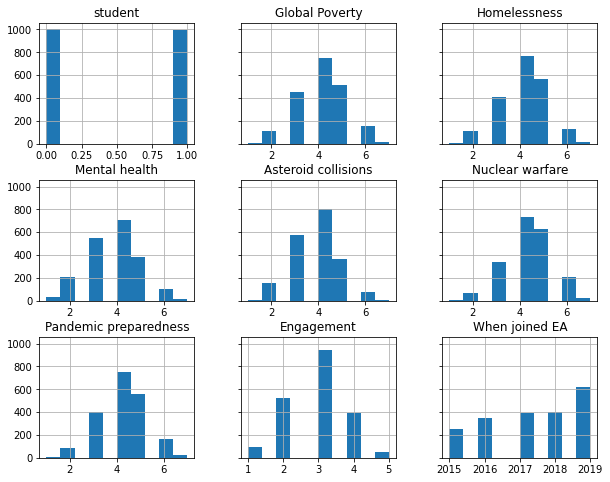

In [6]:
# Looks a bit cruddy without fine-tuning bins, but you get the idea

data.hist(figsize=(10,8),sharey=True)

The 2019 cohort is larger than the previous cohorts, which could be either due to containing 2020ers or because "people who have been involved for more than 1 year are more likely to stay for additional years than people who have not yet been involved for 1 year" (as I initially guessed). Overall, I don't think I will be able to do better than guess "2019 or later" == 2019.

I find the lack of extra examples in 2015 surprising, because it should include 2014, 2013 and so forth. It seems that [there really was rapid growth](https://files.givewell.org/files/metrics/GiveWell_Metrics_Report_2016.pdf#page=8) from 2014-2015, so most of the "2015 and before" cohort might indeed be 2015 joiners.

I might reconsider this if I have time at the end, but for now I'm going to suppose that "2015 and before" is just the 2015 cohort. I initially tried to assign 2/3rds to the 2015 cohort and 1/3rd to the 2014 cohort, but couldn't get the model below to converge and I'd rather move on than spend a long time trouble shooting.

<AxesSubplot:>

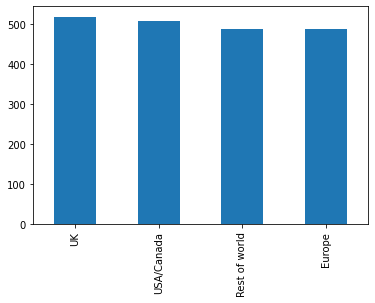

In [7]:
data['Region'].value_counts().plot.bar()

I'm going to try to estimate the hazard ratio, because I'm curious to know what it is. The "n-year hazard ratio" is the probability someone who has been involved in EA drops out after n years. I'm going to set priors with an initial guess that the hazard ratios are 1/3 for 1 year, 1/5 for 2 years, 1/6 for 3 years and so on. This was mainly to get a roughly even distribution of joining dates.

Using GiveWell donor estimates to guess the total size of the EA movement.

Even though I actually expect there to be some drift in the relationship between EA movement size and GiveWell donor counts, I treat the error in this estimate as an independent 10% each year.

In [9]:
# 2015, 2016, 2017, 2018, 2019
# Normalised to 1 EA member in 2019

# Calculates the remaining members who joined in each year since 2015 given 
#  - The hazard rates for each cohort (annual % chance of dropping out after being involved i years)
#  - The total number who joined in each year since 2015
#  - A final year of y
def member_decay(hazards, joineds, y):
    cum_hazards = jnp.array([(1-hazards[:i]).prod() for i in range(y)])[::-1]
    return cum_hazards*joineds[:y]

# Calculates the total members who joined in each year since 2015 given 
#  - The hazard rates for each cohort (annual % chance of dropping out after being involved i years)
#  - The remaining number who joined in each year since 2015
#  - A final year of y
def inverse_member_decay(hazards, remaining, y):
    cum_hazards = jnp.array([(1-hazards[:i]).prod() for i in range(y)])[::-1]
    return remaining[:y]/cum_hazards

EA_TOTAL = jnp.array([2395, 2916, 4150, 4587, 5669])/5669
#EA_TOTAL = jnp.array([1044,2395, 2916, 4150, 4587, 5669])/5669

# Split the 2015 cohort
REMAINING_2019 = data['When joined EA'].value_counts()[::-1].values/2000
# REMAINING_2019 = np.array([REMAINING_2019[0]*1/3] + [REMAINING_2019[0]*2/3] + list(REMAINING_2019[1:]))

TEST_HAZARDS = jnp.array([1/3,1/5,1/6,1/7]) # For testing purposes only
TEST_JOINED = inverse_member_decay(TEST_HAZARDS,REMAINING_2019,5) # For testing purposes only

# Model of member counts and dropout
# The relationship between total number joined each year and remaining cohort from that year is given by functions
# above

# Also assume that there's noise in actual number who join, reported member totals and reported cohort size
# Just set noise to normal distribution with 1SD = 10% reported value in each case, didn't think about it too hard
# The model doesn't converge if I try to use sampling error for the noise, which isn't appropriate anyway
# Because GiveWell donors and survey respondents aren't from the same population

def model(obs_members = None, obs_remaining = None,beta_c1 = None, beta_c2 = None):
    hazards = numpyro.sample('hazard',dist.Beta(beta_c1,beta_c2)) #needs an additional component if you want to split 2015
    joined_est = inverse_member_decay(hazards,obs_remaining,len(obs_remaining))
    joined = numpyro.sample('joined', dist.Normal(joined_est,joined_est*0.1))
    members = jnp.array([member_decay(hazards, joined, y).sum() for y in range(1,1+len(obs_members))])
    meas_members = numpyro.sample('meas_members',dist.Normal(members,members*0.1),obs=obs_members)
    remaining = member_decay(hazards, joined, len(obs_members))
    reported_remain = numpyro.sample('reported_remaining',dist.Normal(remaining,remaining*0.1),obs=obs_remaining)

def prior_only(obs_members = None, obs_remaining = None, beta_c1 = None, beta_c2 = None):
    hazards = numpyro.sample('hazard',dist.Beta(beta_c1,beta_c2))
    joined_est = inverse_member_decay(hazards,obs_remaining,len(obs_remaining))
    joined = numpyro.sample('joined', dist.Normal(joined_est,joined_est*0.1))
    
def run_samples(model,
                obs_members = EA_TOTAL, 
                obs_remaining = REMAINING_2019,
                beta_c1 = [2,2,2,2],
                beta_c2 = [4,8,10,12],
                num_warmup = 2000, 
                num_samples = 2000):
    # Start from this source of randomness. We will split keys for subsequent operations.
    rng_key = random.PRNGKey(0)
    rng_key, rng_key_ = random.split(rng_key)

    # Run NUTS.
    kernel = NUTS(model)
    mcmc = MCMC(kernel, num_warmup=num_warmup, num_samples=num_samples)
    mcmc.run(rng_key_, obs_members = obs_members, obs_remaining = obs_remaining, beta_c1 = beta_c1, beta_c2 = beta_c2)
    mcmc.print_summary()
    samples_1 = mcmc.get_samples()
    return samples_1

samples = run_samples(model)
samples_prior = run_samples(prior_only)
samples_flat = run_samples(model, beta_c2 = [4,4,4,4])

sample: 100%|█| 4000/4000 [00:02<00:00, 1387.81it/s, 15 steps of size 1.56e-01. 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
 hazard[0]      0.35      0.10      0.36      0.18      0.53    828.34      1.00
 hazard[1]      0.14      0.08      0.13      0.02      0.25   1931.98      1.00
 hazard[2]      0.14      0.07      0.13      0.01      0.24   1772.01      1.00
 hazard[3]      0.26      0.11      0.25      0.09      0.44   1079.49      1.00
 joined[0]      0.37      0.03      0.37      0.33      0.41   1620.42      1.00
 joined[1]      0.35      0.05      0.35      0.27      0.43    903.55      1.00
 joined[2]      0.35      0.06      0.35      0.26      0.45    822.93      1.00
 joined[3]      0.31      0.05      0.30      0.22      0.40    801.54      1.00
 joined[4]      0.31      0.02      0.31      0.27      0.34   2029.71      1.00

Number of divergences: 0


sample: 100%|█| 4000/4000 [00:02<00:00, 1799.50it/s, 63 steps of size 1.04e-01. 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
 hazard[0]      0.32      0.18      0.30      0.03      0.57    293.44      1.01
 hazard[1]      0.20      0.12      0.18      0.01      0.37   1072.48      1.00
 hazard[2]      0.17      0.10      0.15      0.01      0.31   1156.17      1.00
 hazard[3]      0.15      0.10      0.13      0.00      0.29   1574.49      1.00
 joined[0]      0.38      0.20      0.33      0.16      0.57    142.39      1.02
 joined[1]      0.44      0.23      0.39      0.20      0.67    148.16      1.02
 joined[2]      0.41      0.21      0.36      0.20      0.61    154.37      1.02
 joined[3]      0.32      0.16      0.29      0.18      0.47    170.52      1.02
 joined[4]      0.31      0.03      0.31      0.26      0.36   1277.89      1.00

Number of divergences: 1


sample: 100%|█| 4000/4000 [00:02<00:00, 1352.40it/s, 15 steps of size 1.32e-01. 


                mean       std    median      5.0%     95.0%     n_eff     r_hat
 hazard[0]      0.25      0.11      0.25      0.07      0.41    704.11      1.00
 hazard[1]      0.14      0.08      0.13      0.02      0.25   1577.26      1.00
 hazard[2]      0.15      0.08      0.14      0.01      0.26   1333.60      1.01
 hazard[3]      0.38      0.11      0.39      0.21      0.56    796.90      1.00
 joined[0]      0.38      0.03      0.38      0.33      0.43   1542.85      1.00
 joined[1]      0.31      0.05      0.31      0.23      0.39    749.33      1.00
 joined[2]      0.30      0.05      0.30      0.22      0.38    654.33      1.00
 joined[3]      0.27      0.04      0.26      0.20      0.33    759.66      1.00
 joined[4]      0.31      0.02      0.31      0.27      0.34   1646.96      1.00

Number of divergences: 0


In [10]:
TEST_JOINED

DeviceArray([0.3255    , 0.39037502, 0.36656252, 0.29850003, 0.308     ],            dtype=float32)

In [11]:
hazard_rates = pd.melt(pd.DataFrame(samples['hazard']),
                       value_vars=[0,1,2,3],
                       var_name = 'years involved', 
                       value_name = 'annual probability of dropout')

hazard_prior = pd.melt(pd.DataFrame(samples_prior['hazard']),
                       value_vars=[0,1,2,3],
                       var_name = 'years involved', 
                       value_name = 'annual probability of dropout')
hazard_flat = pd.melt(pd.DataFrame(samples_flat['hazard']),
                       value_vars=[0,1,2,3],
                       var_name = 'years involved', 
                       value_name = 'annual probability of dropout')

hazard_rates['source'] = 'posterior'
hazard_prior['source'] = 'prior'
hazard_flat['source'] = 'posterior from flat prior'


hazard_rates = hazard_rates.append(hazard_prior).append(hazard_flat)

Annual probability of dropout seems to fall after the first year of involvement

<AxesSubplot:xlabel='years involved', ylabel='annual probability of dropout'>

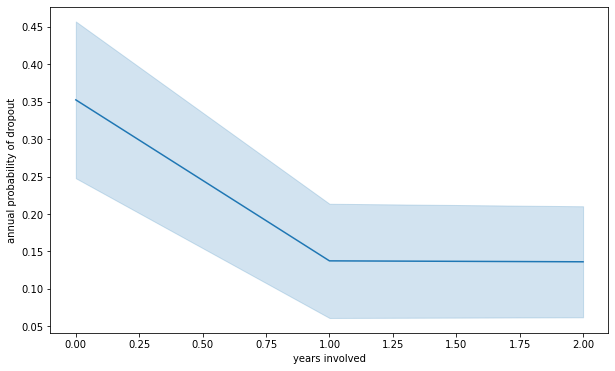

In [12]:
summary = hazard_rates[(hazard_rates['source']=='posterior')&(hazard_rates['years involved']<3)]

fig, ax = plt.subplots(figsize=(10,6))
sns.lineplot(data = summary,x='years involved',y='annual probability of dropout',ci='sd',ax=ax)

For people involved 3 years or longer, the model treats them all as being involved for exactly 3 years, while a substantial number may have been involved 4+ years. This means that the "3 year annual dropout rate" isn't well-specified. However, if the 0, 1 and 2 year rates are correct I think this should bias the result down, not up because the 4 year cohort should drop out less than expected, and this is the opposite of what we find.

This seems to be related to the comment I made at the outset - that there are surprisingly few people in the "2015 or before" cohort, which the model accounts for by giving just this cohort a very high dropout rate.

The model also wants to say that most people joined in the earlier years, which I think is wrong, but this doesn't seem to depend strongly on the priors.

As mentioned above, I tried a crude method to address this, but didn't get the model to converge.

The prior is also plotted to show how the posterior differs.

<AxesSubplot:xlabel='years involved', ylabel='annual probability of dropout'>

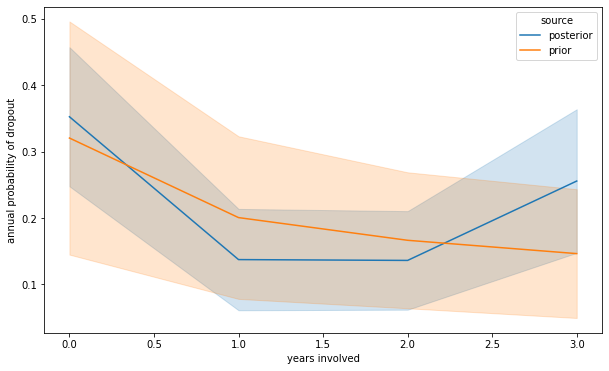

In [13]:
noflat = hazard_rates[hazard_rates['source']!='posterior from flat prior']

fig, ax = plt.subplots(figsize=(10,6))
sns.lineplot(data = noflat,x='years involved',y='annual probability of dropout',ci='sd',hue='source',ax=ax)

<AxesSubplot:xlabel='years involved', ylabel='annual probability of dropout'>

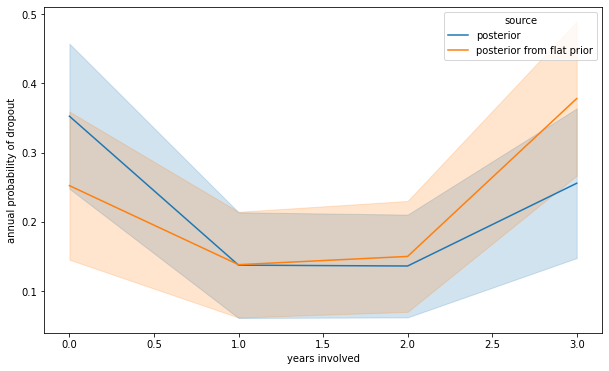

In [14]:
noprior = hazard_rates[hazard_rates['source']!='prior']

fig, ax = plt.subplots(figsize=(10,6))
sns.lineplot(data = noprior,x='years involved',y='annual probability of dropout',ci='sd',hue='source',ax=ax)

We can also visualise how many people would have been picked up by the survey if dropouts and engaged EA community members both participated. As mentioned, I don't think the result with most joiners in 2015 is realistic.

/home/davidj/Code/environments/rethinkpriorities/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


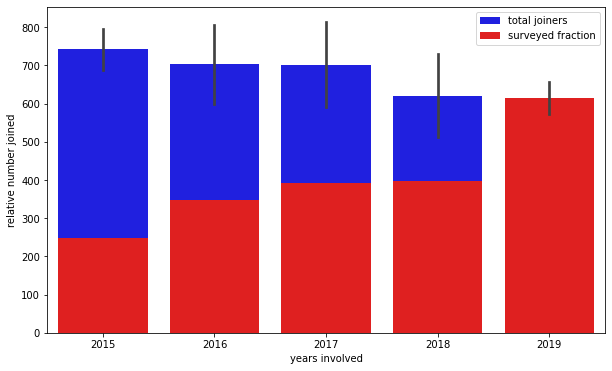

In [15]:
fullcohort = pd.melt(pd.DataFrame(samples['joined']).rename(columns = {0:2015,1:2016,2:2017,3:2018,4:2019})*2000,
                       value_vars=[2015,2016,2017,2018,2019],
                       var_name = 'years involved', 
                       value_name = 'relative number joined')
fig, ax = plt.subplots(figsize=(10,6))
sns.barplot(data = fullcohort,x='years involved',y='relative number joined',ci='sd',ax=ax,color='blue',label='total joiners')
sns.barplot([2015,2016,2017,2018,2019],REMAINING_2019*2000,ax=ax,color='red',label='surveyed fraction')
ax.legend()

In [16]:
np.diff(EA_TOTAL*2000)

array([183.8067 , 435.3501 , 154.17175, 381.72522], dtype=float32)

It's not clear in the GiveWell data that there is a trend towards larger numbers of recruits in later years, so this weak prediction of more recruits in 2015 than 2019 isn't absurd, but it doesn't seem right to me.

I want to have a look at model structure. For calibration, "Student" - "Years involved" (top right) is pretty close to 0 correlation.

<AxesSubplot:>

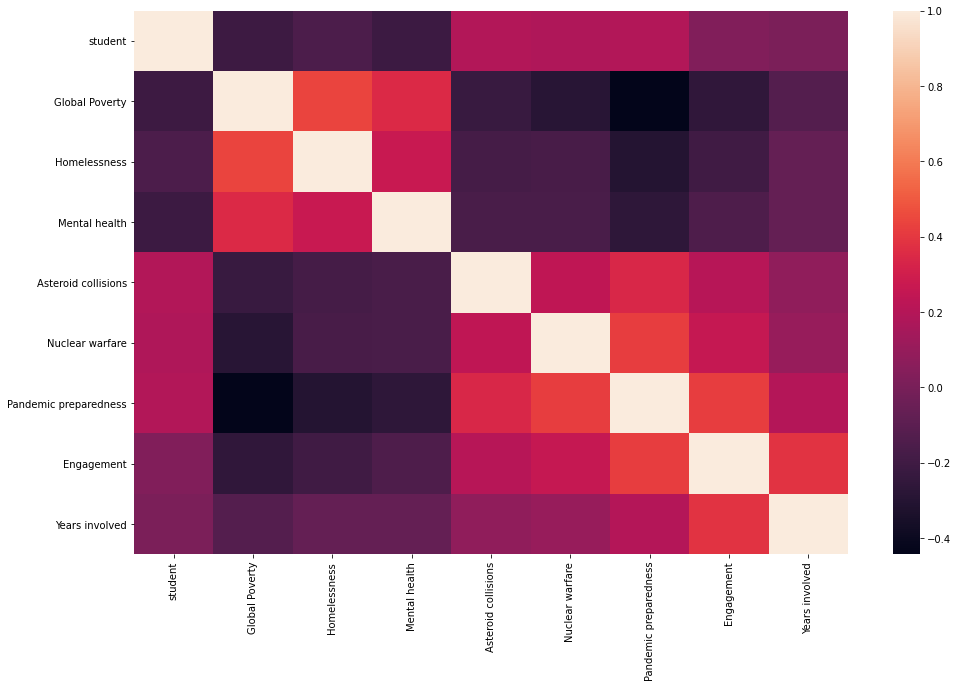

In [17]:
data['Years involved'] = 2019-data['When joined EA']
df = data.drop(columns = ['When joined EA'])
fig, ax = plt.subplots(figsize=(16,10))
sns.heatmap(df.corr(), ax=ax)

In [18]:
df.corr()

,student,Global Poverty,Homelessness,Mental health,Asteroid collisions,Nuclear warfare,Pandemic preparedness,Engagement,Years involved
student,1.000000,-0.210414,-0.152539,-0.214029,0.191466,0.179624,0.192689,0.030120,0.008421
Global Poverty,-0.210414,1.000000,0.437195,0.348269,-0.227045,-0.289223,-0.442419,-0.256671,-0.123992
Homelessness,-0.152539,0.437195,1.000000,0.271795,-0.181196,-0.170828,-0.305427,-0.195120,-0.070069
Mental health,-0.214029,0.348269,0.271795,1.000000,-0.162125,-0.164134,-0.263746,-0.147422,-0.065128
Asteroid collisions,0.191466,-0.227045,-0.181196,-0.162125,1.000000,0.239121,0.336412,0.209953,0.078624
Nuclear warfare,0.179624,-0.289223,-0.170828,-0.164134,0.239121,1.000000,0.415937,0.261707,0.103599
Pandemic preparedness,0.192689,-0.442419,-0.305427,-0.263746,0.336412,0.415937,1.000000,0.415581,0.198093
Engagement,0.030120,-0.256671,-0.195120,-0.147422,0.209953,0.261707,0.415581,1.000000,0.385331
Years involved,0.008421,-0.123992,-0.070069,-0.065128,0.078624,0.103599,0.198093,0.385331,1.000000


On an initial inspection, it looks like there are cause clusters - "low risk focus": {homelessness, mental health, global poverty} and "high risk focus": {asteroid collisions, nuclear warfare, pandemic preparedness}. Students seem to tend towards the latter cluster, and highly engaged/many years involved people tend weakly towards it.

Because it seems like an interesting question to me right now, I want to investigate possible causal relationships between years involved, studenthood and risk focus. To do this, I want to create a single composite "risk focus" variable.

I'm going to do a PCA and see if the leading component is aligned with the risk focus axis.

In [19]:
PRIORITIES = ['Global Poverty',
              'Homelessness',
              'Mental health',
              'Asteroid collisions',
              'Nuclear warfare',
              'Pandemic preparedness']

In [20]:
def standardise(data):
    d = data.copy()
    for col in data.columns:
        d[col] = d[col]-d[col].mean()
        d[col] /= d[col].std()
    return d
        
priorities = standardise(data[PRIORITIES])

pca = PCA(n_components = 2)

pca.fit(priorities)

print(pca.explained_variance_ratio_)

[0.40875095 0.16286938]


In [21]:
pca_priorities = pca.transform(priorities)

/home/davidj/Code/environments/rethinkpriorities/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/davidj/Code/environments/rethinkpriorities/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

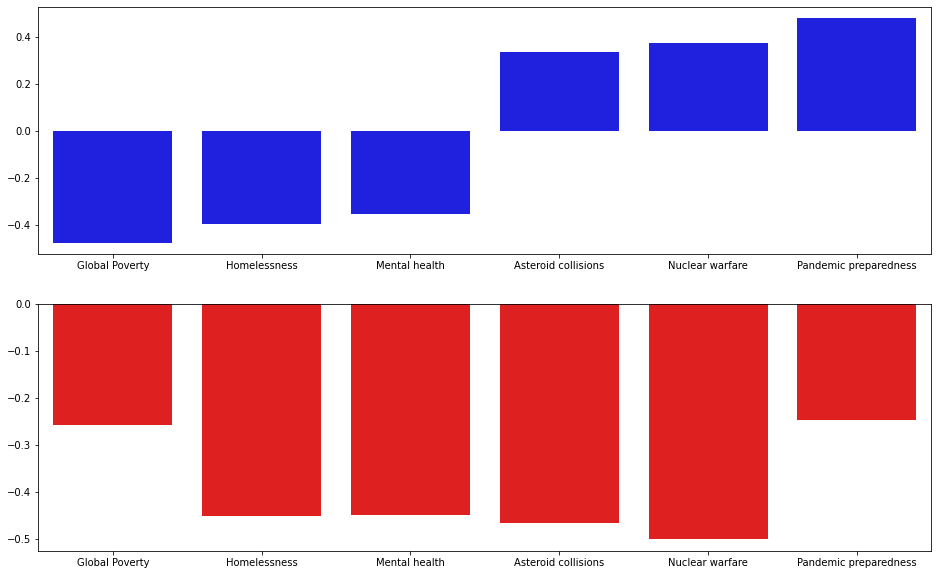

In [22]:
fig, ax = plt.subplots(2,figsize=(16,10))

sns.barplot(PRIORITIES,pca.components_[0],ax=ax[0],color='blue')
sns.barplot(PRIORITIES,pca.components_[1],ax=ax[1],color='red')

The first component is aligned with the risk focus axis, and it explains a lot more variance than the next one. I don't really know how to interpret the second component, at least not quickly.

In [23]:
data['Risk focus'] = pca_priorities[:,0]
compressed_causes = data.drop(columns = PRIORITIES)

<AxesSubplot:>

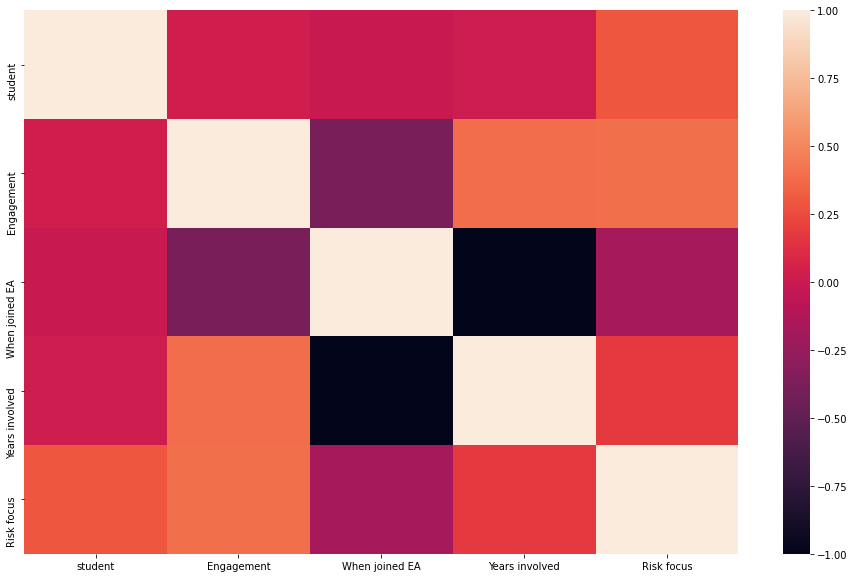

In [24]:
fig, ax = plt.subplots(figsize=(16,10))
sns.heatmap(compressed_causes.corr(), ax=ax)

In [25]:
compressed_causes.corr()

,student,Engagement,When joined EA,Years involved,Risk focus
student,1.000000,0.030120,-0.008421,0.008421,0.295201
Engagement,0.030120,1.000000,-0.385331,0.385331,0.396975
When joined EA,-0.008421,-0.385331,1.000000,-1.000000,-0.173036
Years involved,0.008421,0.385331,-1.000000,1.000000,0.173036
Risk focus,0.295201,0.396975,-0.173036,0.173036,1.000000


There are a number of hypotheses for the correlation between engagement, years involved and risk focus. 

(A) It seems quite likely that being highly engaged causes people to be involved longer. (B) The reverse also seems plausible - that people who are involved for longer build stronger connections and therefore become more engaged.

(1) It could be that high engagement causes high risk focus, for example because many conversations within EA are focussed on risks. 

(2) It could also be the case that lower risk focus causes low engagment, for example people are turned off by risk focussed EA conversations.

(3) Lastly, it could be the case that the cohort of recruits has drifted over time to be less risk focussed and we don't observe the low engagement risk focussed people because they joined a longer time ago and have since dropped out.

I'm getting to the point of being in a hurry and I don't have time to figure out a good way to visualise graphics, so some graphs for the above hypotheses:
(1+A) $\text{Years involved} \leftarrow \mathrm{Engagement}\to \mathrm{Risk focus}$

(1+B) $\text{Years involved} \rightarrow \mathrm{Engagement}\to \mathrm{Risk focus}$

(2+A) $\text{Years involved} \leftarrow \mathrm{Engagement}\leftarrow \mathrm{Risk focus}$

(3) $\text{Engagement} \leftarrow \text{Time (proxied by Years involved)} \to \text{Risk focus}$

And then we could have mixtures of any of these.

(3) might be distinguishable from the rest as it implies $\text{Engagement}\perp \text{Risk focus} | \text{Years involved}$. I'm not 100% sure that it is a sound way to handle missing data. I don't think this is likely to hold as the correlation between years involved and risk focus is much weaker than the correlation between engagement and risk focus.

Also, if we don't have $\text{Years involved}\perp \text{Risk focus} | \text{Engagement}$ then none of the first three graphs can be true (though any could be true with additional arrows).

I'm going to look at some partial correlations for fun


In [26]:
pingouin.partial_corr(compressed_causes,x='Engagement',y='Risk focus',covar='Years involved')

,n,r,CI95%,p-val
pearson,2000,0.363421,"[0.32, 0.4]",1.837807e-63


Graph (3) is definitely not right, then. This doesn't mean that the pattern it expresses can be ruled out (cohort drift), but it would need to be a pattern within a graph with some other connections.

In [27]:
pingouin.partial_corr(compressed_causes,x='Years involved',y='Risk focus',covar='Engagement')

,n,r,CI95%,p-val
pearson,2000,0.023696,"[-0.02, 0.07]",0.289625


With a partial correlation this low, we can't rule out $\text{Years involved}\perp \text{Risk focus} | \text{Engagement}$, so any of the first three graphs are plausible without modification. That is, engagement seems to mediate the relationship between risk focus and years involved, though we can't necessarily tell which way the relationships run.

I have a suspicion that we have studenthood and engagement both causing risk focus.

In [28]:
pingouin.partial_corr(compressed_causes,x='student',y='Engagement')

,n,r,CI95%,p-val
pearson,2000,0.03012,"[-0.01, 0.07]",0.178148


In [29]:
pingouin.partial_corr(compressed_causes,x='student',y='Engagement',covar='Risk focus')

,n,r,CI95%,p-val
pearson,2000,-0.099287,"[-0.14, -0.06]",0.000009


This suggests that our causal graph has some structure like $\text{student} \to \text{Risk focus} \leftarrow \text{Engagement}$, which rules out graph (2A)

So, from this brief investigation of conditional independences, of the graphs initially proposed the two candidates we are left with are

(1+A) $\text{Years involved} \leftarrow \mathrm{Engagement}\to \mathrm{Risk focus}$

(1+B) $\text{Years involved} \rightarrow \mathrm{Engagement}\to \mathrm{Risk focus}$

As I said at the outset, I think that the level of engagement is highly likely to lead to people being involved for longer, which suggests there is some truth to the interpretation of graph (1A): highly engaged community members are likely to be involved in EA longer and more risk focussed as a result. 

However, I think it is entirely plausible that years of involvement could also cause higher reported engagment.

I'm pretty unconfident in this conclusion as it relies on not having thought of any other plausible graphs, and also on a bunch of assumptions that imply this method of investigating graphs is meaningful to begin with.

Time elapsed: 4:37. I'm going to use the rest of my time to set up a virtual environment to make dependencies easy to handle.